In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat

In [2]:
path = "/home/intern4/fm2026/fm_flow/code_it/logs"
run_idx = 28
run_ep = 12
log_root = Path(path) / f"{run_idx:05d}_train/test/ep_{run_ep}"
res_files = sorted(log_root.glob("*.mat"))
print(len(res_files))

96


In [3]:
idx = -1
# idx = 100

In [4]:
idx += 1
res_mat = loadmat(res_files[idx])
print(res_mat.keys())
print(res_mat['instruction_raw'])
# print(res_mat['task_name'])
# print(res_mat['instruction'])

dict_keys(['__header__', '__version__', '__globals__', 'input', 'out', 'label', 'text', 'instruction', 'instruction_raw', 'task_name'])
['Denoise this T1 brain MRI slice and preserve anatomy under coarse noise after that segment the tumor in this T1 brain MRI slice.']


60
['Denoise this T2 brain MRI slice with slight noise after that mark the tumor location in this T2 brain MRI slice.']
Full Image  - Dice: 0.9596
Vis Crop    - Dice: 0.9596


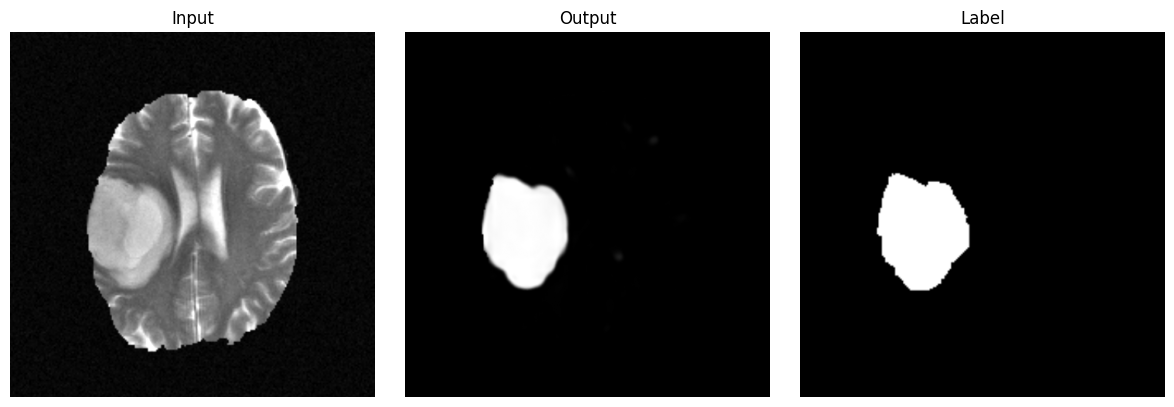

In [64]:
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
from skimage.measure import label as sk_label

idx += 1
print(idx)

res_mat = loadmat(res_files[idx])
input = res_mat["input"].squeeze()
out = res_mat["out"].squeeze()
label = res_mat["label"].squeeze()
print(res_mat['instruction_raw'])

def _get_task_name(res_mat):
    tn = res_mat.get("task_name", "")
    try:
        if hasattr(tn, "size") and tn.size == 1:
            tn = tn.ravel()[0]
        if isinstance(tn, bytes):
            return tn.decode()
        if hasattr(tn, "dtype") and tn.dtype.kind in ("U", "S"):
            return "".join(tn.tolist()) if getattr(tn, "ndim", 0) > 0 else str(tn)
        return str(tn)
    except Exception:
        return str(tn)

def dice_score(pred, gt, thresh=0.5, eps=1e-7):
    pred_bin = pred > thresh
    gt_bin = gt > thresh
    inter = (pred_bin & gt_bin).sum()
    denom = pred_bin.sum() + gt_bin.sum()
    return (2.0 * inter + eps) / (denom + eps)

x1, x2, y1, y2 = 20, -20, 20, -20

vmin_input = np.percentile(input, 0.5)
vmax_input = np.percentile(input, 99.5)
vmin_out = np.percentile(out, 0.5)
vmax_out = np.percentile(out, 99.5)
vmin_label = np.percentile(label, 0.5)
vmax_label = np.percentile(label, 99.5)

def brain_mask_by_background(label_img, bg_thresh=None):
    if bg_thresh is None:
        bg_thresh = np.percentile(label_img, 1)
    bg = label_img <= bg_thresh
    cc = sk_label(bg, connectivity=2)
    if cc.max() == 0:
        return np.ones_like(bg, dtype=bool)
    sizes = np.bincount(cc.ravel())
    sizes[0] = 0
    bg_largest = (cc == sizes.argmax())
    brain = ~bg_largest
    return brain

mask = brain_mask_by_background(label)

task_name = _get_task_name(res_mat)

# Full image metrics
if "segmentation" in task_name:
    dice_full = dice_score(out, label)
else:
    psnr_full = psnr(label, out, data_range=label.max() - label.min())
    ssim_full = ssim(label, out, data_range=label.max() - label.min())

# Masked metrics
if "segmentation" not in task_name:
    psnr_masked = psnr(label[mask], out[mask], data_range=label.max() - label.min())

rows = np.any(mask, axis=1)
cols = np.any(mask, axis=0)
label_crop_mask = label[rows][:, cols]
out_crop_mask = out[rows][:, cols]
# ssim_masked = ssim(label_crop_mask, out_crop_mask, data_range=label.max() - label.min())

# Visualization crop metrics
label_vis_crop = label[x1:x2, y1:y2]
out_vis_crop = out[x1:x2, y1:y2]
if "segmentation" in task_name:
    dice_vis_crop = dice_score(out_vis_crop, label_vis_crop)
else:
    psnr_vis_crop = psnr(label_vis_crop, out_vis_crop, data_range=label_vis_crop.max() - label_vis_crop.min())
    ssim_vis_crop = ssim(label_vis_crop, out_vis_crop, data_range=label_vis_crop.max() - label_vis_crop.min())

if "segmentation" in task_name:
    print(f"Full Image  - Dice: {dice_full:.4f}")
    print(f"Vis Crop    - Dice: {dice_vis_crop:.4f}")
else:
    print(f"Full Image  - PSNR: {psnr_full:.4f} | SSIM: {ssim_full:.4f}")
    # print(f"Masked      - PSNR: {psnr_masked:.4f} | SSIM: {ssim_masked:.4f}")
    print(f"Vis Crop    - PSNR: {psnr_vis_crop:.4f} | SSIM: {ssim_vis_crop:.4f}")

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(input[x1:x2, y1:y2], cmap="gray", vmin=vmin_input, vmax=vmax_input)
plt.title("Input")
plt.axis("off")
plt.subplot(1, 3, 2)
plt.imshow(out[x1:x2, y1:y2], cmap="gray", vmin=vmin_out, vmax=vmax_out)
plt.title("Output")
plt.axis("off")
plt.subplot(1, 3, 3)
plt.imshow(label[x1:x2, y1:y2], cmap="gray", vmin=vmin_label, vmax=vmax_label)
plt.title("Label")
plt.axis("off")
# plt.subplot(1, 4, 4)
# diff = np.abs(label[x1:x2, y1:y2] - out[x1:x2, y1:y2])
# plt.imshow(diff, cmap="hot")
# plt.title("Label-Output Difference")
# plt.axis("off")
plt.tight_layout()
plt.show()


In [87]:
# metric calculation over the dataset
import re

run_idx = 0
run_ep = 12
log_root = Path(path) / f"{run_idx:05d}_train/test/ep_{run_ep}"
res_files = sorted(log_root.glob("*.mat"))

cnt = 0
psnr_tot = []
ssim_tot = []
dice_tot = []

def _get_task_name(res_mat):
    tn = res_mat.get("task_name", "")
    try:
        if hasattr(tn, "size") and tn.size == 1:
            tn = tn.ravel()[0]
        if isinstance(tn, bytes):
            return tn.decode()
        if hasattr(tn, "dtype") and tn.dtype.kind in ("U", "S"):
            return "".join(tn.tolist()) if getattr(tn, "ndim", 0) > 0 else str(tn)
        return str(tn)
    except Exception:
        return str(tn)

def dice_score(pred, gt, thresh=0.5, eps=1e-7):
    pred_bin = pred > thresh
    gt_bin = gt > thresh
    inter = (pred_bin & gt_bin).sum()
    denom = pred_bin.sum() + gt_bin.sum()
    return (2.0 * inter + eps) / (denom + eps)
            
for i in range(len(res_files)):
    res_mat = loadmat(res_files[i])
    input = res_mat["input"].squeeze()
    out = res_mat["out"].squeeze()
    label = res_mat["label"].squeeze()

    instruction = res_mat["instruction"][0]
    if any(x in instruction.flatten() for x in [263]):
        continue

    task_name = _get_task_name(res_mat)
    cnt = cnt + 1

    if task_name == "segmentation":
        dice_value = dice_score(out, label)
        dice_tot.append(dice_value)
        continue

    data_range = float(label.max() - label.min())
    psnr_value = psnr(label, out, data_range=data_range)
    ssim_value = ssim(label, out, data_range=data_range)
    psnr_tot.append(psnr_value)
    ssim_tot.append(ssim_value)

if psnr_tot:
    print(f"PSNR: {np.mean(psnr_tot):.2f} ± {np.std(psnr_tot):.2f}")
    print(f"SSIM: {np.mean(ssim_tot):.4f} ± {np.std(ssim_tot):.4f}")
if dice_tot:
    print(f"Dice: {np.mean(dice_tot):.4f} ± {np.std(dice_tot):.4f}")
print("count:", cnt)


PSNR: 23.15 ± 3.00
SSIM: 0.7834 ± 0.0795
count: 81


In [192]:
# metric calculation with background masking
import re

run_idx = 0
run_ep = 12
log_root = Path(path) / f"{run_idx:05d}_train/test/ep_{run_ep}"
res_files = sorted(log_root.glob("*.mat"))
path = "/home/intern4/fm2026/fm_flow/code_it/logs"

cnt = 0
psnr_tot_masked = []
ssim_tot_masked = []
dice_tot = []

# threshold to separate background from MRI
bg_threshold = 1e-3

def _get_task_name(res_mat):
    tn = res_mat.get("task_name", "")
    try:
        if hasattr(tn, "size") and tn.size == 1:
            tn = tn.ravel()[0]
        if isinstance(tn, bytes):
            return tn.decode()
        if hasattr(tn, "dtype") and tn.dtype.kind in ("U", "S"):
            return "".join(tn.tolist()) if getattr(tn, "ndim", 0) > 0 else str(tn)
        return str(tn)
    except Exception:
        return str(tn)

def dice_score(pred, gt, thresh=0.5, eps=1e-7):
    pred_bin = pred > thresh
    gt_bin = gt > thresh
    inter = (pred_bin & gt_bin).sum()
    denom = pred_bin.sum() + gt_bin.sum()
    return (2.0 * inter + eps) / (denom + eps)
            
for i in range(len(res_files)):
    res_mat = loadmat(res_files[i])
    input = res_mat["input"].squeeze()
    out = res_mat["out"].squeeze()
    label = res_mat["label"].squeeze()

    instruction = res_mat["instruction"][0]
    if any(x in instruction.flatten() for x in [263]):
        continue

    task_name = _get_task_name(res_mat)
    cnt = cnt + 1

    if task_name == "segmentation":
        dice_value = dice_score(out, label)
        dice_tot.append(dice_value)
        continue

    # Create mask: 1 where label is not background, 0 where it is background
    mask = (np.abs(label) > bg_threshold).astype(np.float32)
    
    # Apply mask
    label_masked = label * mask
    out_masked = out * mask
    
    # Calculate metrics only on masked region
    data_range = float(label_masked.max() - label_masked.min())
    if data_range > 0:  # Only calculate if there's valid data
        psnr_value = psnr(label_masked, out_masked, data_range=data_range)
        ssim_value = ssim(label_masked, out_masked, data_range=data_range)
        psnr_tot_masked.append(psnr_value)
        ssim_tot_masked.append(ssim_value)

print("=" * 50)
print("With Background Masking:")
print("=" * 50)
if psnr_tot_masked:
    print(f"PSNR: {np.mean(psnr_tot_masked):.2f} ± {np.std(psnr_tot_masked):.2f}")
    print(f"SSIM: {np.mean(ssim_tot_masked):.4f} ± {np.std(ssim_tot_masked):.4f}")
if dice_tot:
    print(f"Dice: {np.mean(dice_tot):.4f} ± {np.std(dice_tot):.4f}")
print(f"Count: {cnt}")
print(f"Threshold: {bg_threshold}")


With Background Masking:
PSNR: nan ± nan
SSIM: nan ± nan
Count: 0
Threshold: 0.001


In [193]:
# Debug: check label data range
run_idx = 0
run_ep = 12
log_root = Path(path) / f"{run_idx:05d}_train/test/ep_{run_ep}"
res_files = sorted(log_root.glob("*.mat"))

all_labels = []
for i in range(min(10, len(res_files))):  # Check first 10 files
    res_mat = loadmat(res_files[i])
    label = res_mat["label"].squeeze()
    all_labels.append(label)
    print(f"File {i}: min={label.min():.6f}, max={label.max():.6f}, mean={label.mean():.6f}, std={label.std():.6f}")

all_labels_arr = np.concatenate([l.flatten() for l in all_labels])
print("\n" + "=" * 50)
print("Overall statistics (first 10 files):")
print("=" * 50)
print(f"Global min: {all_labels_arr.min():.6f}")
print(f"Global max: {all_labels_arr.max():.6f}")
print(f"Global mean: {all_labels_arr.mean():.6f}")
print(f"Global std: {all_labels_arr.std():.6f}")
print(f"Percentile 5%: {np.percentile(all_labels_arr, 5):.6f}")
print(f"Percentile 95%: {np.percentile(all_labels_arr, 95):.6f}")
print(f"Number of zeros: {np.sum(all_labels_arr == 0)}")
print(f"Number of non-zeros: {np.sum(all_labels_arr != 0)}")

File 0: min=-0.660149, max=2.881717, mean=0.000000, std=1.000000
File 1: min=-0.788506, max=3.514080, mean=-0.000000, std=1.000000
File 2: min=-0.450598, max=6.052998, mean=-0.000000, std=1.000000
File 3: min=-0.784501, max=6.948224, mean=-0.000000, std=1.000000
File 4: min=-0.751216, max=5.513452, mean=-0.000000, std=1.000000
File 5: min=-0.814879, max=5.065539, mean=0.000000, std=1.000000
File 6: min=-0.749793, max=4.816784, mean=-0.000000, std=1.000000
File 7: min=-0.681741, max=6.338806, mean=0.000000, std=1.000000
File 8: min=-0.699406, max=4.125102, mean=0.000000, std=1.000000
File 9: min=-0.668095, max=3.395234, mean=-0.000000, std=1.000000

Overall statistics (first 10 files):
Global min: -0.814879
Global max: 6.948224
Global mean: -0.000000
Global std: 1.000000
Percentile 5%: -0.777143
Percentile 95%: 1.972402
Number of zeros: 0
Number of non-zeros: 2621440


In [194]:
# metric calculation with background masking - adjusted threshold
import re

run_idx = 0
run_ep = 12
log_root = Path(path) / f"{run_idx:05d}_train/test/ep_{run_ep}"
res_files = sorted(log_root.glob("*.mat"))

cnt = 0
psnr_tot_masked = []
ssim_tot_masked = []
dice_tot = []

# Use percentile-based threshold instead of absolute threshold
# Background pixels are in the bottom 10% of values
bg_percentile = 10

def _get_task_name(res_mat):
    tn = res_mat.get("task_name", "")
    try:
        if hasattr(tn, "size") and tn.size == 1:
            tn = tn.ravel()[0]
        if isinstance(tn, bytes):
            return tn.decode()
        if hasattr(tn, "dtype") and tn.dtype.kind in ("U", "S"):
            return "".join(tn.tolist()) if getattr(tn, "ndim", 0) > 0 else str(tn)
        return str(tn)
    except Exception:
        return str(tn)

def dice_score(pred, gt, thresh=0.5, eps=1e-7):
    pred_bin = pred > thresh
    gt_bin = gt > thresh
    inter = (pred_bin & gt_bin).sum()
    denom = pred_bin.sum() + gt_bin.sum()
    return (2.0 * inter + eps) / (denom + eps)
            
for i in range(len(res_files)):
    res_mat = loadmat(res_files[i])
    input = res_mat["input"].squeeze()
    out = res_mat["out"].squeeze()
    label = res_mat["label"].squeeze()

    instruction = res_mat["instruction"][0]
    if any(x in instruction.flatten() for x in [263]):
        continue

    task_name = _get_task_name(res_mat)
    cnt = cnt + 1

    if task_name == "segmentation":
        dice_value = dice_score(out, label)
        dice_tot.append(dice_value)
        continue

    # Create mask based on label percentile
    bg_threshold = np.percentile(np.abs(label), bg_percentile)
    mask = (np.abs(label) > bg_threshold).astype(np.float32)
    
    # Apply mask
    label_masked = label * mask
    out_masked = out * mask
    
    # Calculate metrics only on masked region
    data_range = float(label_masked.max() - label_masked.min())
    if data_range > 0:  # Only calculate if there's valid data
        psnr_value = psnr(label_masked, out_masked, data_range=data_range)
        ssim_value = ssim(label_masked, out_masked, data_range=data_range)
        psnr_tot_masked.append(psnr_value)
        ssim_tot_masked.append(ssim_value)

print("=" * 50)
print(f"With Background Masking (bottom {bg_percentile}% as background):")
print("=" * 50)
if psnr_tot_masked:
    print(f"PSNR: {np.mean(psnr_tot_masked):.2f} ± {np.std(psnr_tot_masked):.2f}")
    print(f"SSIM: {np.mean(ssim_tot_masked):.4f} ± {np.std(ssim_tot_masked):.4f}")
if dice_tot:
    print(f"Dice: {np.mean(dice_tot):.4f} ± {np.std(dice_tot):.4f}")
print(f"Count: {cnt}")
print(f"Files with valid metrics: {len(psnr_tot_masked) + len(dice_tot)}")

print("\n" + "=" * 50)
print("Compare with original (no masking):")
print("=" * 50)
if psnr_tot:
    print(f"PSNR: {np.mean(psnr_tot):.2f} ± {np.std(psnr_tot):.2f}")
    print(f"SSIM: {np.mean(ssim_tot):.4f} ± {np.std(ssim_tot):.4f}")
if dice_tot:
    print(f"Dice: {np.mean(dice_tot):.4f} ± {np.std(dice_tot):.4f}")


With Background Masking (bottom 10% as background):
PSNR: 23.84 ± 3.03
SSIM: 0.8327 ± 0.0690
Count: 81
Files with valid metrics: 81

Compare with original (no masking):
PSNR: 23.15 ± 3.00
SSIM: 0.7834 ± 0.0795


In [51]:
print(input.shape)
print(input.min(), input.max())
print(input.mean(), input.std())
print(input)

(512, 512)
-0.8030505 5.236048
-8.568168e-08 1.0
[[-0.8030505 -0.8030505 -0.8030505 ... -0.8030505 -0.8030505 -0.8030505]
 [-0.8030505 -0.8030505 -0.8030505 ... -0.8030505 -0.8030505 -0.8030505]
 [-0.8030505 -0.8030505 -0.8030505 ... -0.8030505 -0.8030505 -0.8030505]
 ...
 [-0.8030505 -0.8030505 -0.8030505 ... -0.8030505 -0.8030505 -0.8030505]
 [-0.8030505 -0.8030505 -0.8030505 ... -0.8030505 -0.8030505 -0.8030505]
 [-0.8030505 -0.8030505 -0.8030505 ... -0.8030505 -0.8030505 -0.8030505]]


using /home/intern4/fm2026/fm_flow/code_it/logs_past/00000_train/test/ep_0/100_res.mat


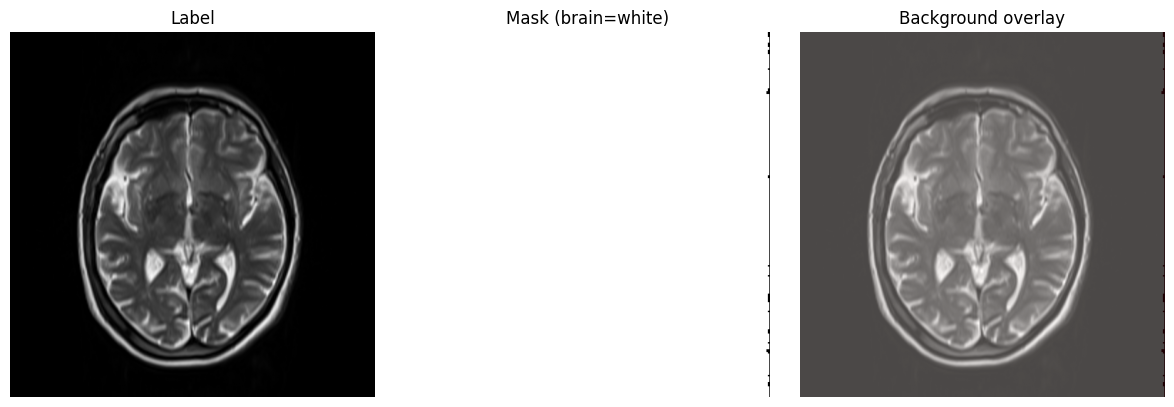

In [93]:
# Visualize background-based mask (largest connected background)
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from skimage.measure import label

# Pick a res_mat file
res_dir = Path("/home/intern4/fm2026/fm_flow/code_it/logs_past/00000_train/test/ep_0")
res_path = sorted(res_dir.glob("*_res.mat"))[0]
print("using", res_path)

m = loadmat(res_path)
label_img = np.array(m["label"]).squeeze()
out_img = np.array(m["out"]).squeeze()

def brain_mask_by_background(label_img, bg_thresh=None):
    if bg_thresh is None:
        bg_thresh = np.percentile(label_img, 1)
    bg = label_img <= bg_thresh
    cc = label(bg, connectivity=2)
    if cc.max() == 0:
        return np.ones_like(bg, dtype=bool)
    sizes = np.bincount(cc.ravel())
    sizes[0] = 0
    bg_largest = (cc == sizes.argmax())
    brain = ~bg_largest
    return brain

mask = brain_mask_by_background(label_img)

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(label_img, cmap="gray")
axes[0].set_title("Label")
axes[0].axis("off")
axes[1].imshow(mask, cmap="gray")
axes[1].set_title("Mask (brain=white)")
axes[1].axis("off")
axes[2].imshow(label_img, cmap="gray")
axes[2].imshow(~mask, cmap="Reds", alpha=0.3)
axes[2].set_title("Background overlay")
axes[2].axis("off")
plt.tight_layout()


In [ ]:
# Masked PSNR/SSIM using background-connected mask
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
from skimage.measure import label

idx += 1
print(idx)

res_mat = loadmat(res_files[idx])
input = res_mat["input"].squeeze()
out = res_mat["out"].squeeze()
label = res_mat["label"].squeeze()

def _get_task_name(res_mat):
    tn = res_mat.get("task_name", "")
    try:
        if hasattr(tn, "size") and tn.size == 1:
            tn = tn.ravel()[0]
        if isinstance(tn, bytes):
            return tn.decode()
        if hasattr(tn, "dtype") and tn.dtype.kind in ("U", "S"):
            return "".join(tn.tolist()) if getattr(tn, "ndim", 0) > 0 else str(tn)
        return str(tn)
    except Exception:
        return str(tn)

def dice_score(pred, gt, thresh=0.5, eps=1e-7):
    pred_bin = pred > thresh
    gt_bin = gt > thresh
    inter = (pred_bin & gt_bin).sum()
    denom = pred_bin.sum() + gt_bin.sum()
    return (2.0 * inter + eps) / (denom + eps)

def brain_mask_by_background(label_img, bg_thresh=None):
    if bg_thresh is None:
        bg_thresh = np.percentile(label_img, 1)
    bg = label_img <= bg_thresh
    cc = label(bg, connectivity=2)
    if cc.max() == 0:
        return np.ones_like(bg, dtype=bool)
    sizes = np.bincount(cc.ravel())
    sizes[0] = 0
    bg_largest = (cc == sizes.argmax())
    brain = ~bg_largest
    return brain

mask = brain_mask_by_background(label)

task_name = _get_task_name(res_mat)
if task_name == "segmentation":
    dice_value = dice_score(out, label)
    print(f"Dice: {dice_value:.4f}")
else:
    psnr_value = psnr(label[mask], out[mask], data_range=label.max() - label.min())
    ssim_value = ssim(label, out, data_range=label.max() - label.min(), mask=mask)
    print(f"Masked PSNR: {psnr_value:.4f}")
    print(f"Masked SSIM: {ssim_value:.4f}")

x1, x2, y1, y2 = 20, -20, 20, -20
vmin_input = np.percentile(input, 0.5)
vmax_input = np.percentile(input, 99.5)
vmin_out = np.percentile(out, 0.5)
vmax_out = np.percentile(out, 99.5)
vmin_label = np.percentile(label, 0.5)
vmax_label = np.percentile(label, 99.5)

plt.figure(figsize=(18, 4))
plt.subplot(1, 4, 1)
plt.imshow(input[x1:x2, y1:y2], cmap="gray", vmin=vmin_input, vmax=vmax_input)
plt.title("Input")
plt.axis("off")
plt.subplot(1, 4, 2)
plt.imshow(out[x1:x2, y1:y2], cmap="gray", vmin=vmin_out, vmax=vmax_out)
plt.title("Output")
plt.axis("off")
plt.subplot(1, 4, 3)
plt.imshow(label[x1:x2, y1:y2], cmap="gray", vmin=vmin_label, vmax=vmax_label)
plt.title("Label")
plt.axis("off")
plt.subplot(1, 4, 4)
diff = np.abs(label[x1:x2, y1:y2] - out[x1:x2, y1:y2])
plt.imshow(diff, cmap="hot")
plt.title("Label-Output Difference")
plt.axis("off")
plt.tight_layout()
plt.show()
